In [1]:
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.interpolate import splprep, splev
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter

ideal_df = pd.read_csv("../data/extracted_track_data/ks_barcelona/layout1/ideal_line.csv")
image_path = "../data/assetto_corsa_tracks/Already_Processed_Tracks/ks_barcelona/layout_gp/map.png"

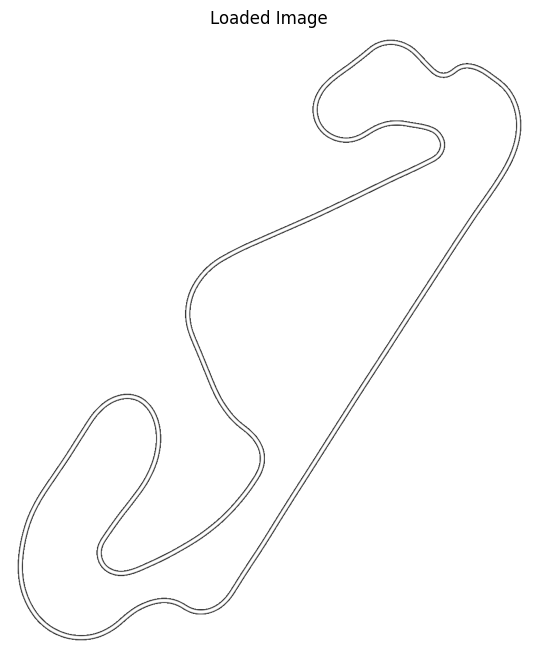

In [2]:
# Load the transparent PNG image and plt
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA))
plt.axis('off')
plt.title('Loaded Image')
plt.show()

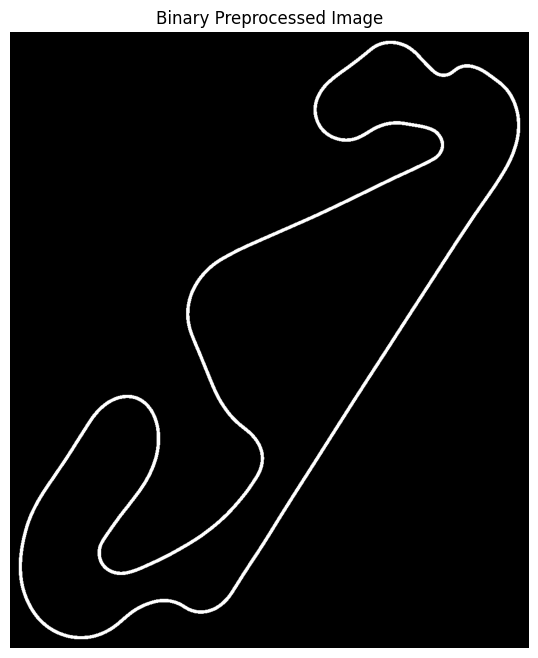

In [3]:
# Convert transparent image to binary (white track and black edges)
alpha_channel = image[:, :, 3]
gray_image = cv2.cvtColor(image, cv2.COLOR_BGRA2GRAY)
_, binary = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)
binary[alpha_channel == 0] = 0

plt.figure(figsize=(8, 8))
plt.imshow(binary, cmap='gray')
plt.axis('off')
plt.title('Binary Preprocessed Image')
plt.show()

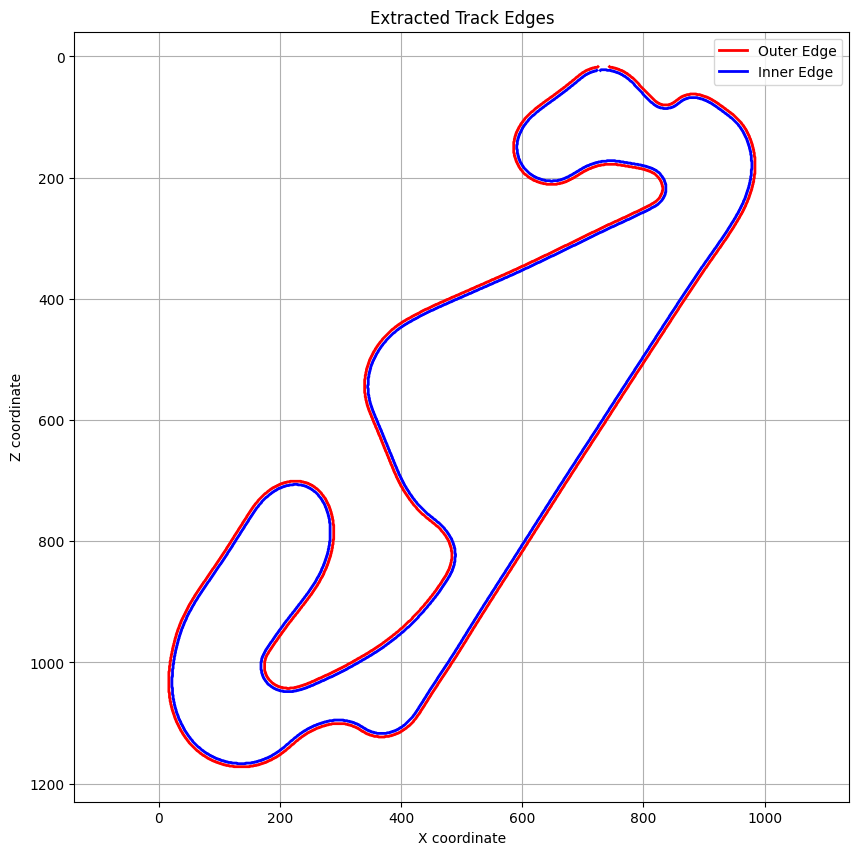

In [4]:
# Extract edges using contours and hierarchy
contours, hierarchy = cv2.findContours(binary, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
outer_edge = sorted_contours[0].squeeze()
inner_edge = sorted_contours[1].squeeze()

# Plot edges
plt.figure(figsize=(10, 10))
plt.plot(outer_edge[:, 0], outer_edge[:, 1], 'r-', label='Outer Edge', linewidth=2)
plt.plot(inner_edge[:, 0], inner_edge[:, 1], 'b-', label='Inner Edge', linewidth=2)

# Adjust plot aesthetics
plt.gca().invert_yaxis()  # images have origin at top-left corner
plt.axis('equal')
plt.legend()
plt.title('Extracted Track Edges')
plt.xlabel('X coordinate')
plt.ylabel('Z coordinate')
plt.grid(True)
plt.show()

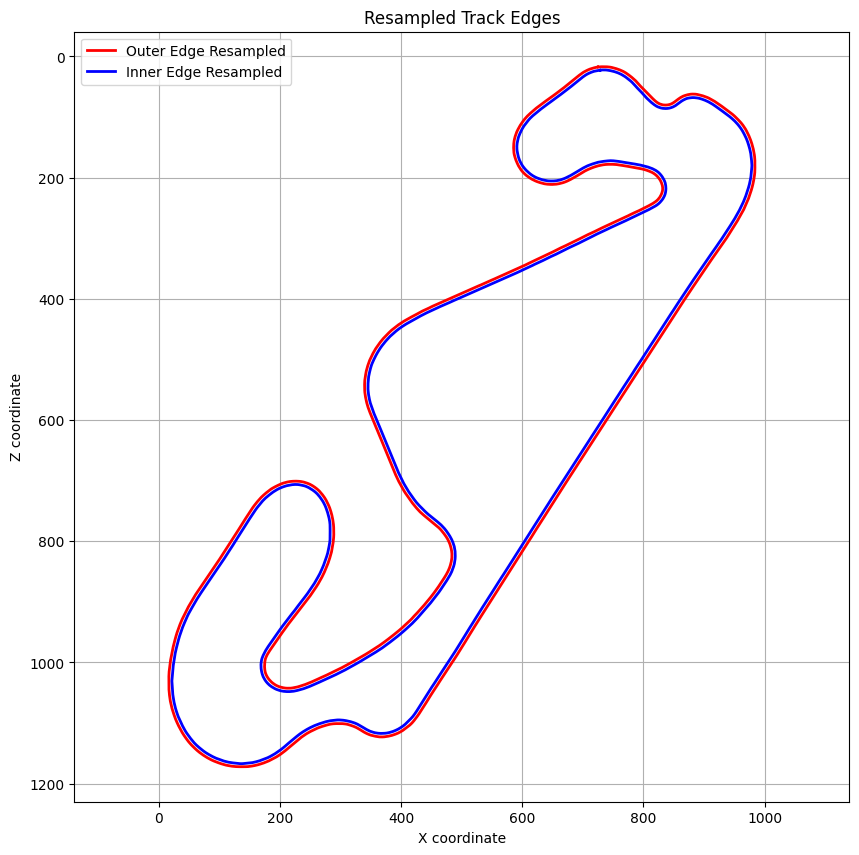

In [5]:
# Resampling edge to get correct number of points around the track to match ideal_df


# Option 1: Pre-smoothing using Gaussian Filtering (line that is most down/rightward drifts left/upward)
def resample_edge(edge, num_points, smoothing=5, sigma=1):
    # Pre-smooth coordinates separately
    x_smooth = gaussian_filter1d(edge[:, 0], sigma=sigma, mode='wrap')
    z_smooth = gaussian_filter1d(edge[:, 1], sigma=sigma, mode='wrap')

    # Perform spline interpolation on smoothed points
    tck, u = splprep([x_smooth, z_smooth], s=smoothing, per=True)
    u_new = np.linspace(0, 1, num_points)
    x_new, z_new = splev(u_new, tck)

    return np.vstack([x_new, z_new]).T


# Option 2: Adaptive smoothing based on curvature 
def curvature(x, z):
    dx = np.gradient(x)
    dz = np.gradient(z)
    ddx = np.gradient(dx)
    ddz = np.gradient(dz)
    curv = np.abs(dx * ddz - dz * ddx) / (dx**2 + dz**2)**1.5
    return curv

def adaptive_resample_edge(edge, num_points, base_sigma=1, curve_thresh=0.005):
    # Calculate curvature
    curv = curvature(edge[:,0], edge[:,1])

    # Set sigma smaller where curvature is high, larger otherwise
    adaptive_sigma = np.where(curv > curve_thresh, base_sigma / 2, base_sigma)

    x_smooth = np.array([gaussian_filter1d(edge[:,0], sigma=s, mode='wrap')[i] for i, s in enumerate(adaptive_sigma)])
    z_smooth = np.array([gaussian_filter1d(edge[:,1], sigma=s, mode='wrap')[i] for i, s in enumerate(adaptive_sigma)])

    # Gentle spline smoothing
    tck, u = splprep([x_smooth, z_smooth], s=2, per=True)
    u_new = np.linspace(0, 1, num_points)
    x_new, z_new = splev(u_new, tck)

    return np.vstack([x_new, z_new]).T

# option 3: Arc-length Resampling with Savitzky-Golay Smoothing (best? marginally)
def resample_edge_savitzky(edge, num_points, window_length=15, polyorder=3):
    # Close loop explicitly
    edge = np.vstack([edge, edge[0]])

    # Calculate cumulative distance (arc-length)
    distances = np.sqrt(np.diff(edge[:,0])**2 + np.diff(edge[:,1])**2)
    cumulative_distance = np.insert(np.cumsum(distances), 0, 0)
    total_length = cumulative_distance[-1]

    # Uniformly spaced points along the distance
    uniform_distances = np.linspace(0, total_length, num_points)

    # Interpolate x and z coordinates linearly
    interp_x = interp1d(cumulative_distance, edge[:,0], kind='linear')
    interp_z = interp1d(cumulative_distance, edge[:,1], kind='linear')

    x_resampled = interp_x(uniform_distances)
    z_resampled = interp_z(uniform_distances)

    # Mild smoothing using Savitzky-Golay (no directional drift)
    x_smooth = savgol_filter(x_resampled, window_length, polyorder, mode='wrap')
    z_smooth = savgol_filter(z_resampled, window_length, polyorder, mode='wrap')

    return np.vstack([x_smooth, z_smooth]).T



num_points = len(ideal_df)
# outer_resampled = resample_edge(outer_edge, num_points)
# inner_resampled = resample_edge(inner_edge, num_points)
# outer_resampled = adaptive_resample_edge(outer_edge, num_points)
# inner_resampled = adaptive_resample_edge(inner_edge, num_points)
outer_resampled = resample_edge_savitzky(outer_edge, num_points)
inner_resampled = resample_edge_savitzky(inner_edge, num_points)

# Plot resampled edges
plt.figure(figsize=(10, 10))
plt.plot(outer_resampled[:, 0], outer_resampled[:, 1], 'r-', label='Outer Edge Resampled', linewidth=2)
plt.plot(inner_resampled[:, 0], inner_resampled[:, 1], 'b-', label='Inner Edge Resampled', linewidth=2)

# Aesthetic adjustments
plt.gca().invert_yaxis()
plt.axis('equal')
plt.legend()
plt.title('Resampled Track Edges')
plt.xlabel('X coordinate')
plt.ylabel('Z coordinate')
plt.grid(True)
plt.show()

In [ ]:
# Need this function and whatever resampling algorithm from above for preprocessing
def process_track_image(image_path, ideal_df, resample, window_length, polyorder):
    # Load image
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

    # Convert transparent image to binary (white track and black edges)
    alpha_channel = image[:, :, 3]
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGRA2GRAY)
    _, binary = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)
    binary[alpha_channel < 255] = 0 # could also have alpha_channel = 0 for strictly transparent 

    # Extract edges using contours
    contours, _ = cv2.findContours(binary, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
    outer_edge = sorted_contours[0].squeeze()
    inner_edge = sorted_contours[1].squeeze()

    # Resample edges to match ideal_line_df size
    num_points = len(ideal_df)
    if resample == 0: # Gaussian Filtering 
        outer_edge_resampled = resample_edge(outer_edge, num_points)
        inner_edge_resampled = resample_edge(inner_edge, num_points)
    elif resample == 1: # Adaptive smoothing based on curvature 
        outer_edge_resampled = adaptive_resample_edge(outer_edge, num_points)
        inner_edge_resampled = adaptive_resample_edge(inner_edge, num_points)
    elif resample == 2: # Arc-length Resampling with Savitzky-Golay Smoothing
        outer_edge_resampled = resample_edge_savitzky(outer_edge, num_points, window_length, polyorder)
        inner_edge_resampled = resample_edge_savitzky(inner_edge, num_points, window_length, polyorder)
    else:
        print("0,1,2 for resample algorithms")

    # Create DataFrame (x, z plane; y is zero)
    track_edges_df = pd.DataFrame({
        'left_x': outer_edge_resampled[:, 0],
        'left_y': 0,
        'left_z': outer_edge_resampled[:, 1],
        'right_x': inner_edge_resampled[:, 0],
        'right_y': 0,
        'right_z': inner_edge_resampled[:, 1]
    })

    return track_edges_df

In [7]:
# Example usage
df = process_track_image(image_path, ideal_df, resample=2, window_length=15, polyorder=3) # 0 = Gaussian Filtering, 1 = Adaptive smoothing, 2 = Arc-length Resampling & Savitzky-Golay
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2928 entries, 0 to 2927
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   left_x   2928 non-null   float64
 1   left_y   2928 non-null   int64  
 2   left_z   2928 non-null   float64
 3   right_x  2928 non-null   float64
 4   right_y  2928 non-null   int64  
 5   right_z  2928 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 137.4 KB


,left_x,left_y,left_z,right_x,right_y,right_z
0,724.448691,0,17.378002,729.524443,0,22.451117
1,723.127918,0,17.625551,730.880005,0,22.268239
2,721.787112,0,17.879395,732.261395,0,22.195980
3,720.428368,0,18.181028,733.662856,0,22.166150
4,719.052191,0,18.568110,735.107570,0,22.141382


In [8]:
def plot_track_edges_with_map(
    edge_df,
    map_image_path=None,
    offset=(0, 0),
    scale=1.0,
    title="Track Edges + Map"
):
    fig, ax = plt.subplots(figsize=(16, 16), dpi=150)

    # Plot background map image if provided
    if map_image_path:
        img = Image.open(map_image_path)
        w, h = img.size
        extent = [
            offset[0], offset[0] + w * scale,
            offset[1] + h * scale, offset[1]
        ]
        ax.imshow(img, extent=extent, origin="upper", alpha=0.6)

    # Plot left and right edges
    ax.plot(edge_df["left_x"], edge_df["left_z"], color="blue", label="Left Edge", linewidth=0.8)
    ax.plot(edge_df["right_x"], edge_df["right_z"], color="red", label="Right Edge", linewidth=0.8)

    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("z")
    ax.set_aspect("equal")
    ax.legend()
    plt.grid(True)
    plt.show()

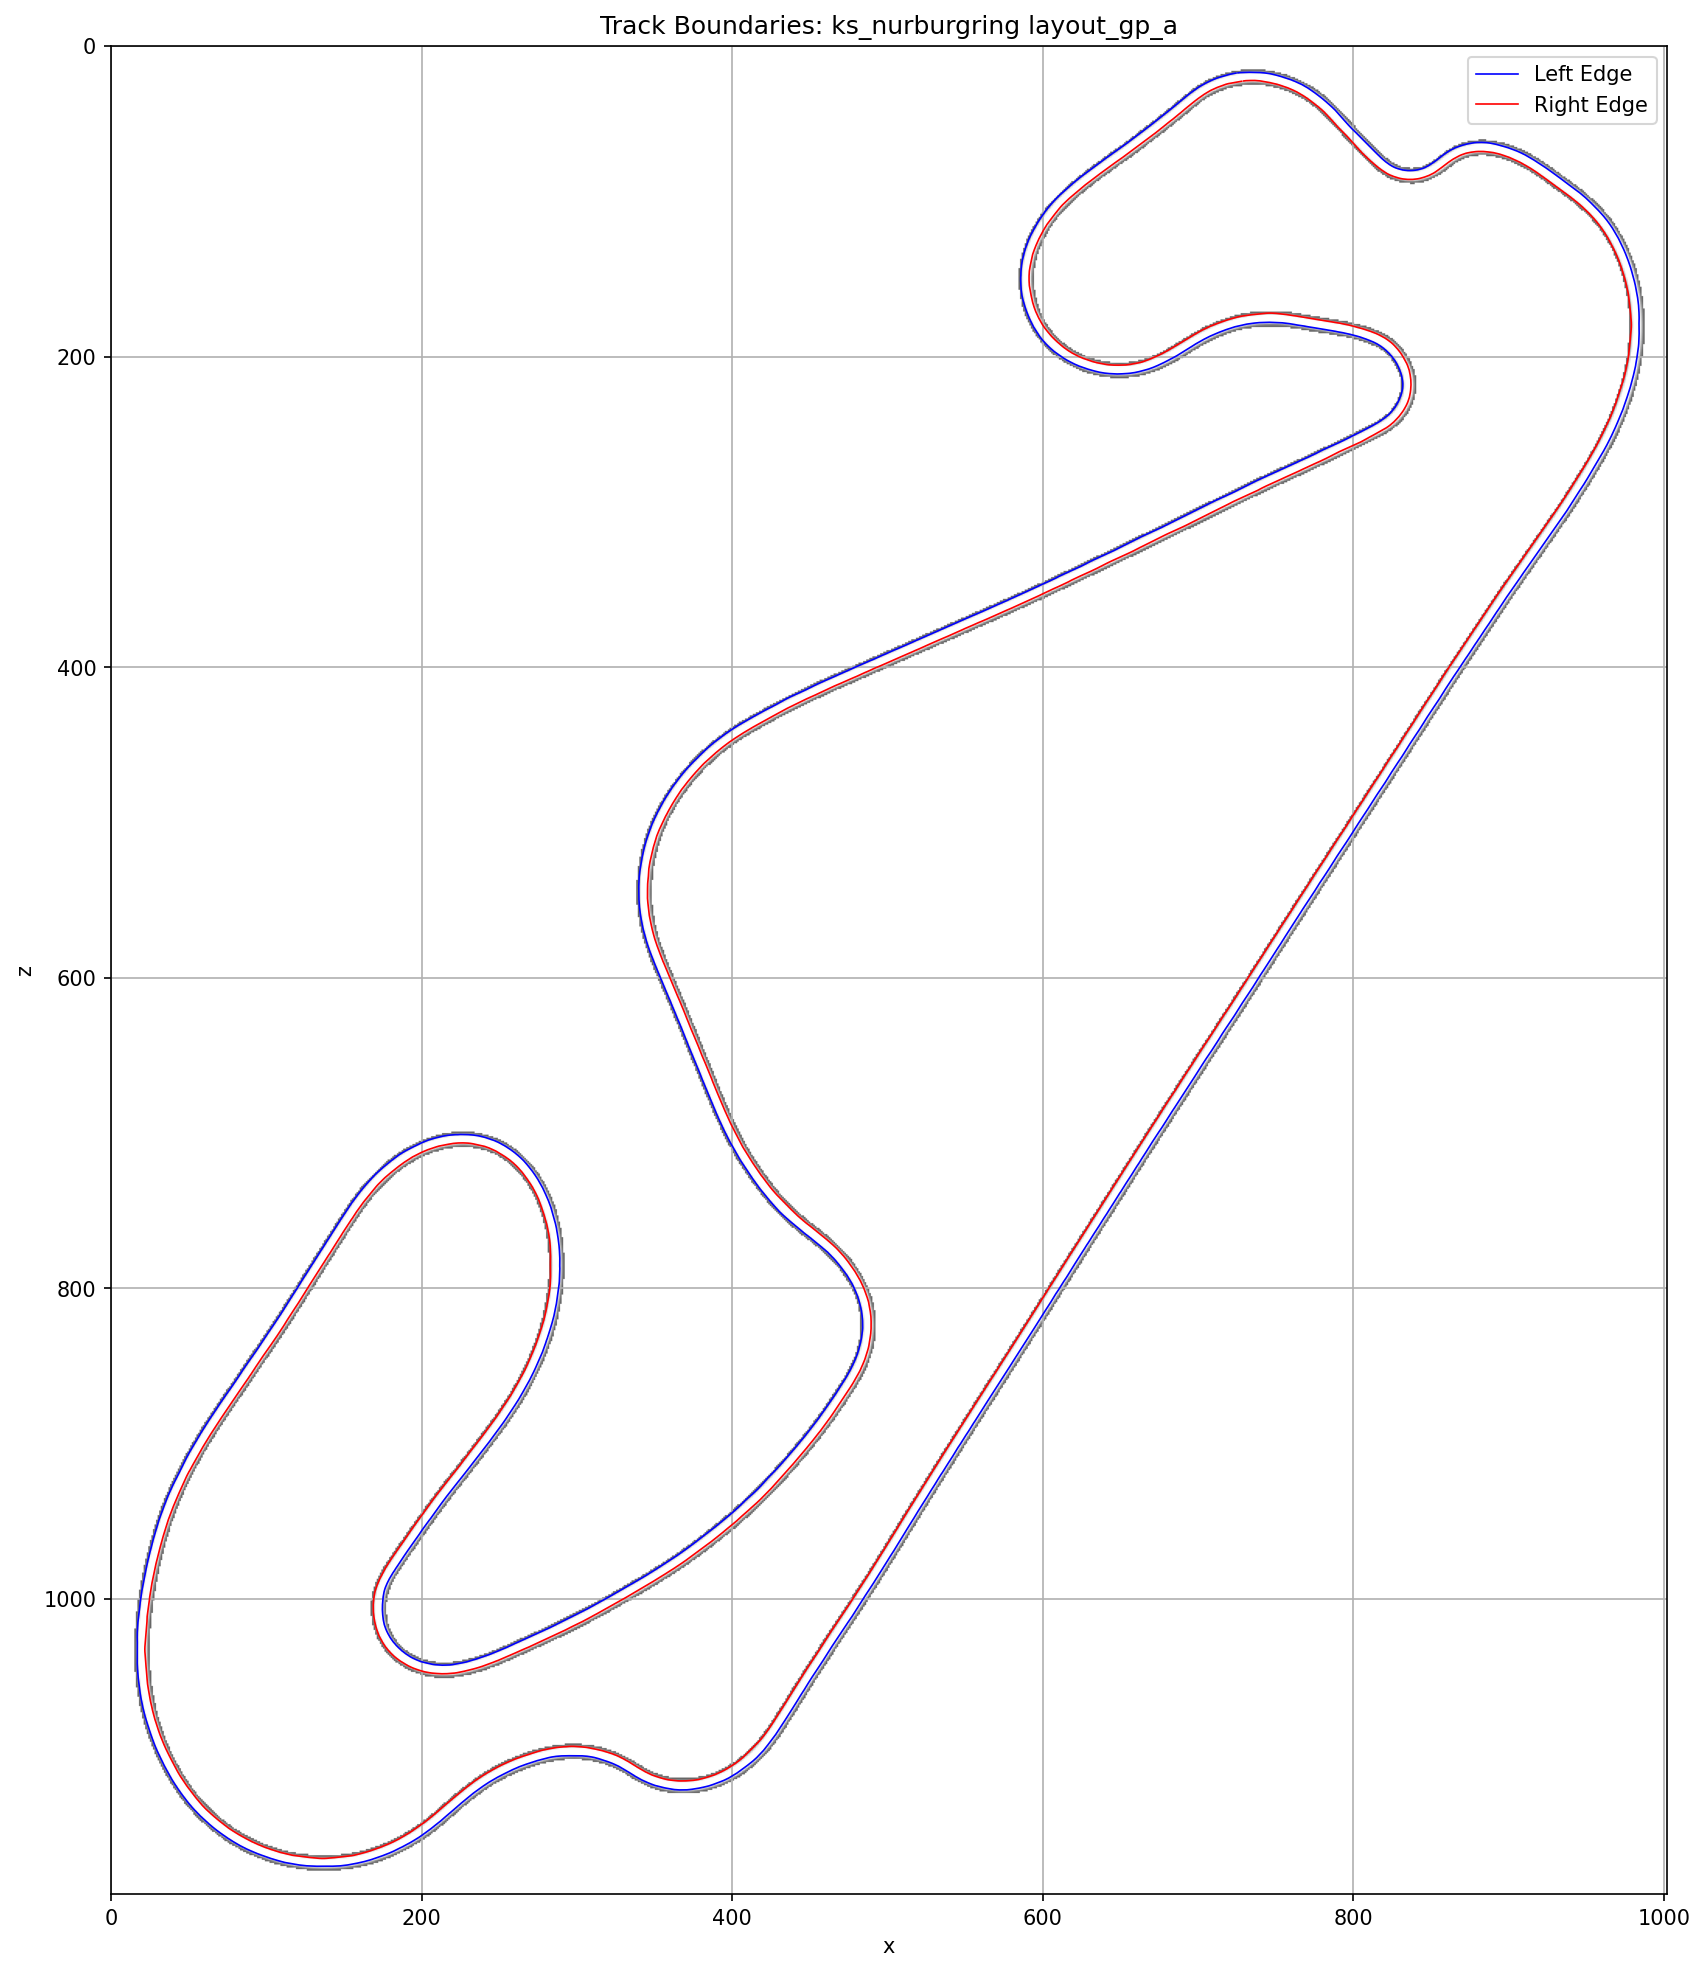

In [9]:
plot_track_edges_with_map(
    df,
    map_image_path=image_path,
    title="Track Boundaries: ks_nurburgring layout_gp_a"
)